## Подключение библиотек

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

In [4]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

## Пути к директориям и файлам

In [6]:
TRAIN_DATASET_PATH = './train.csv'
TEST_DATASET_PATH = './test.csv'

## 1. Загрузка данных

Цель - предсказать стоимость квартир.

Считываем данные. По строкам - наблюдения, по столбцам - признаки.

In [7]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


Уменьшаем размер данных

In [8]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [9]:
train_df.shape

(10000, 20)

In [10]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

Пропущены данные в признаках LifeSquare и Healthcare_1. 
Признаки Ecology_2, Ecology_3 и Shops_2 необходимо преобразовать в числовые.
В трейне 10000 строк.

Количественные признаки: 
Square,  LifeSquare, KitchenSquare, Rooms, Floor, HouseFloor, HouseYear

Категориальные признаки:
Id, DistrictId, Ecology_2, Ecology_3, Shops_2, Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2, Shops_1

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=',')
test_df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B


In [12]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [13]:
test_df.shape

(5000, 19)

In [14]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

В тестовых данных также пропущены данные в признаках LifeSquare и Healthcare_1. 
Признаки Ecology_2, Ecology_3 и Shops_2 необходимо преобразовать в числовые.
В тесте 5000 строк.

## 2. Приведение типов данных

Так как Id и DistrictId категориальный, а не целочисленный тип данных, то преобразуем эти признаки к строковому типу данных.

In [15]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [16]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

In [17]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Из представленных результатов можно сделать следующие выводы:
1) В признаке Rooms минимальное количество комнат равно 0, что вероятнее всего является ошибкой.

2) Значение признака Square (общая жилая площадь) не должно быть меньше суммы значений признаков LifeSquare	(жилая площадь) и KitchenSquare (площадь кухни).

3) Минимальное количество этажей в доме (признак HouseFloor) не должно быть равно 0.

4) Максимальное значение года постройки дома (признак HouseYear) не должно быть больше текущего года.

5) Максимальное значение признаков Rooms, Square, LifeSquare, KitchenSquare имеют слишком большое отклонение от их средних значений.

## 3. Explotary Data Analisys

###  3.1 Визуализация
### Целевая переменная

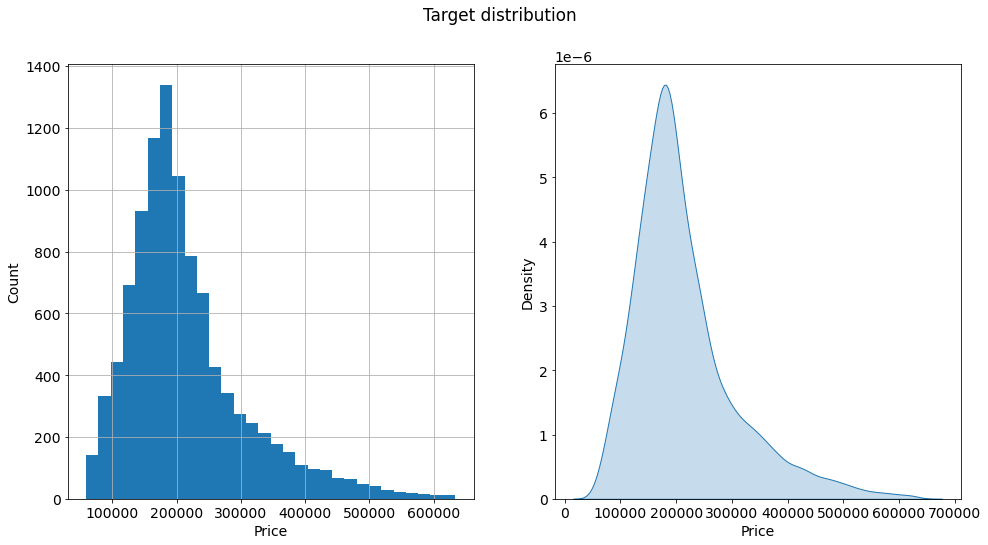

In [18]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Target distribution')
plt.show()

In [19]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]
print(target_mean)
print(target_median)
print(target_mode)

214138.94
192269.65625
182938.08


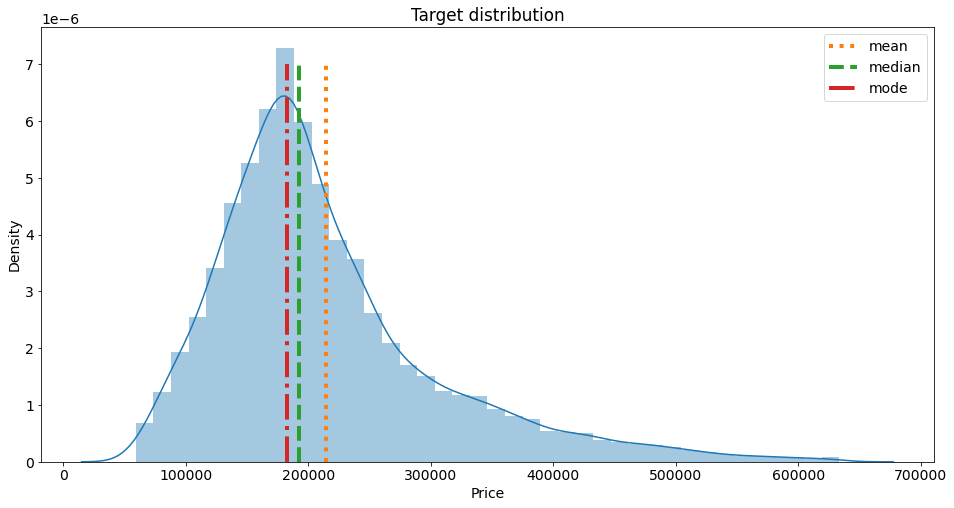

In [20]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=40)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Target distribution')
plt.legend()
plt.show()

Целевая переменная имеет распределение плостности близкое к нормальному.
Целевая переменная не содержит странных значений

### Количественные переменные

In [21]:
train_df_num_features = train_df[['Rooms','Square','LifeSquare','KitchenSquare','Floor','HouseFloor','HouseYear']]
train_df_num_features.head(4)

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear
0,3.0,115.027313,NaN,10.0,4,10.0,2014
1,1.0,39.832523,23.169222,8.0,7,8.0,1966
2,3.0,78.342216,47.671970,10.0,2,17.0,1988
3,1.0,40.409908,NaN,1.0,10,22.0,1977


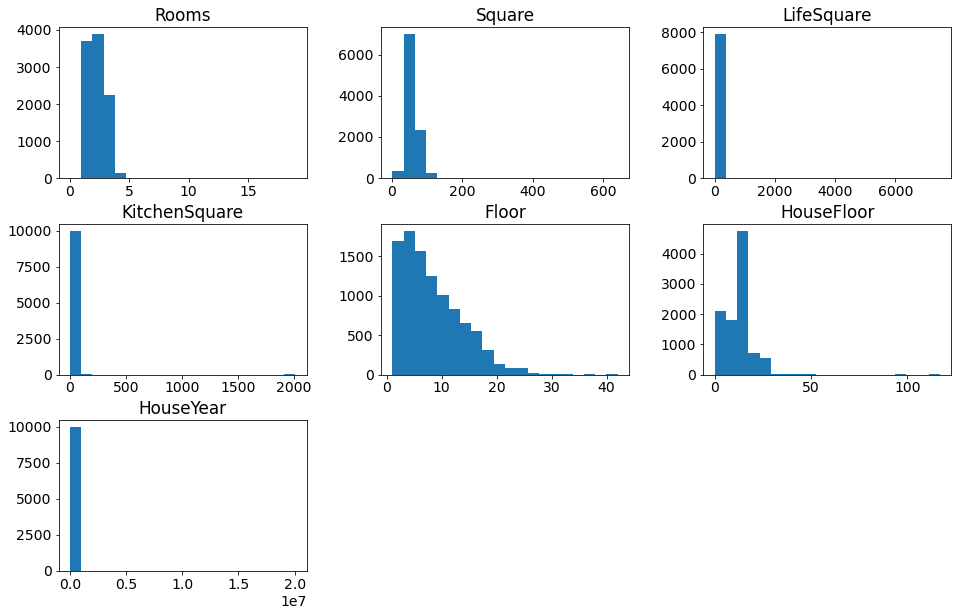

In [22]:
train_df_num_features.hist(figsize=(16,10), bins=20, grid=False);

Признаки Square, LifeSquare, KitchenSquare и HouseYear содержат явные выбросы. В признаках Rooms и HouseFloor есть данные, где количество значений мало. 

### Категориальные переменные

### Номинативные переменные

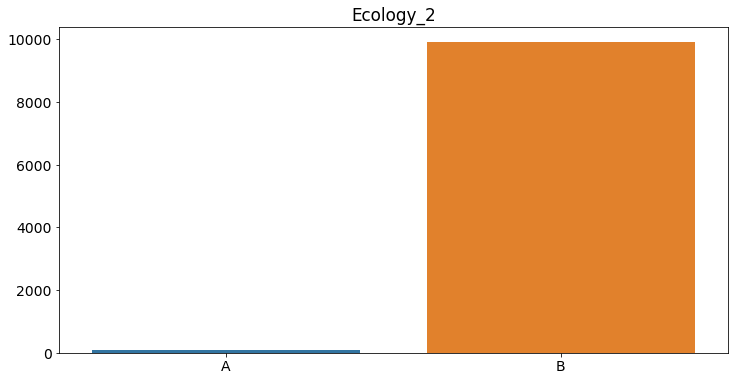

In [23]:
counts = train_df['Ecology_2'].value_counts()
plt.figure(figsize=(12,6))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

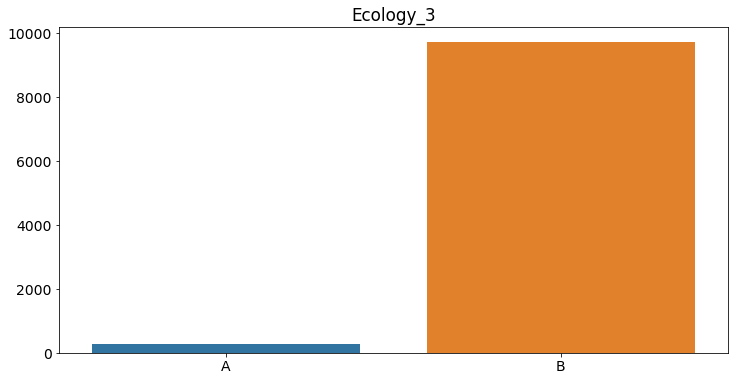

In [24]:
counts2 = train_df['Ecology_3'].value_counts()
plt.figure(figsize=(12,6))    
plt.title('Ecology_3')
sns.barplot(counts2.index, counts2.values)
    
plt.show()

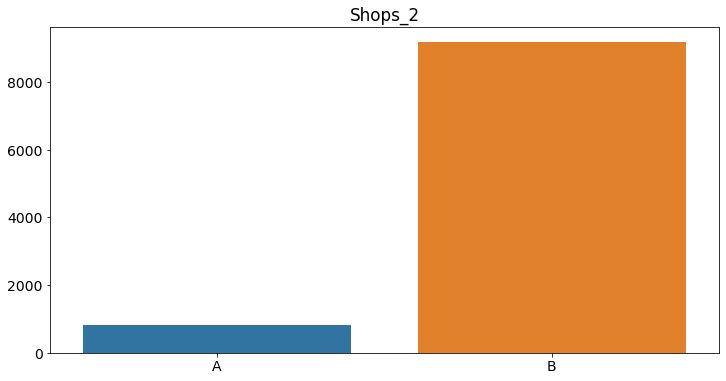

In [25]:
counts3 = train_df['Shops_2'].value_counts()
plt.figure(figsize=(12,6))    
plt.title('Shops_2')
sns.barplot(counts3.index, counts3.values)
    
plt.show()

Типов данных А намного меньше, чем типов данных B, особенно в признаке Ecology_2.

### Прочие категориальные переменные

In [26]:
train_df_order_features = train_df[['Ecology_1','Healthcare_1','Social_1','Social_2','Social_3','Shops_1']]
train_df_order_features.head(4)

,Ecology_1,Healthcare_1,Social_1,Social_2,Social_3,Shops_1
0,0.075424,NaN,11,3097,0,0
1,0.118537,1183.0,30,6207,1,0
2,0.025609,240.0,33,5261,0,1
3,0.007122,NaN,1,264,0,1


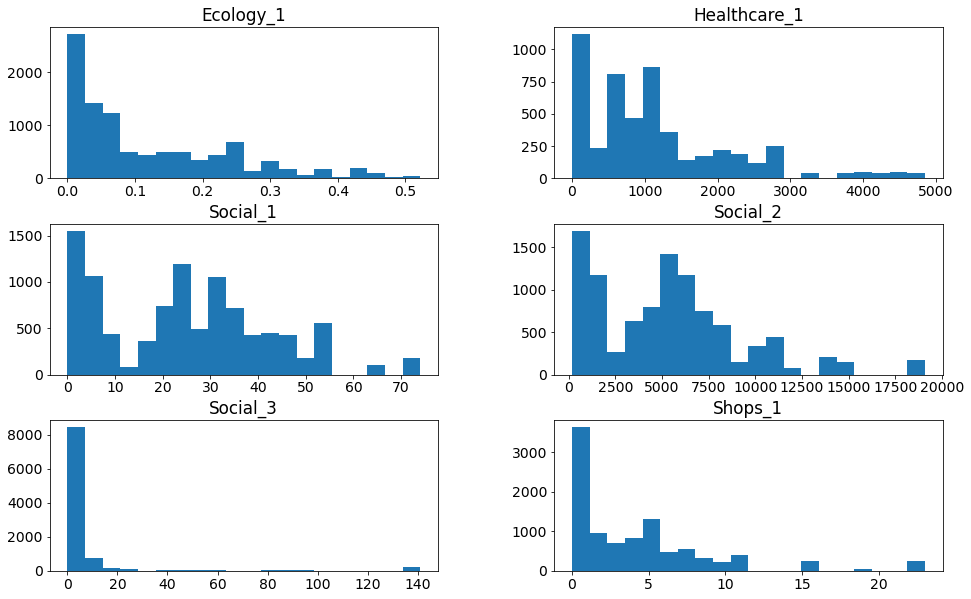

In [27]:
train_df_order_features.hist(figsize=(16,10), bins=20, grid=False);

В признаке Social_3 есть данные, где количество значений мало.

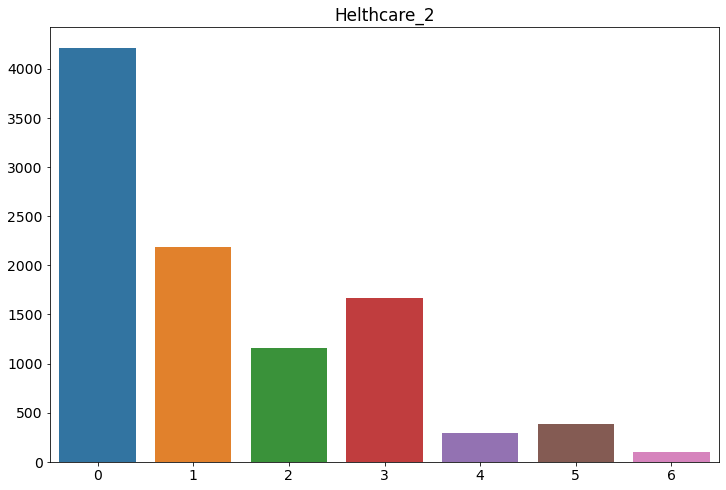

In [28]:
counts4 = train_df['Helthcare_2'].value_counts()

plt.figure(figsize=(12,8))    
plt.title('Helthcare_2')
sns.barplot(counts4.index, counts4.values)
    
plt.show()

### Матрица корреляций

Строим матрицу корреляций, чтобы исключить сильно коррелированные признаки

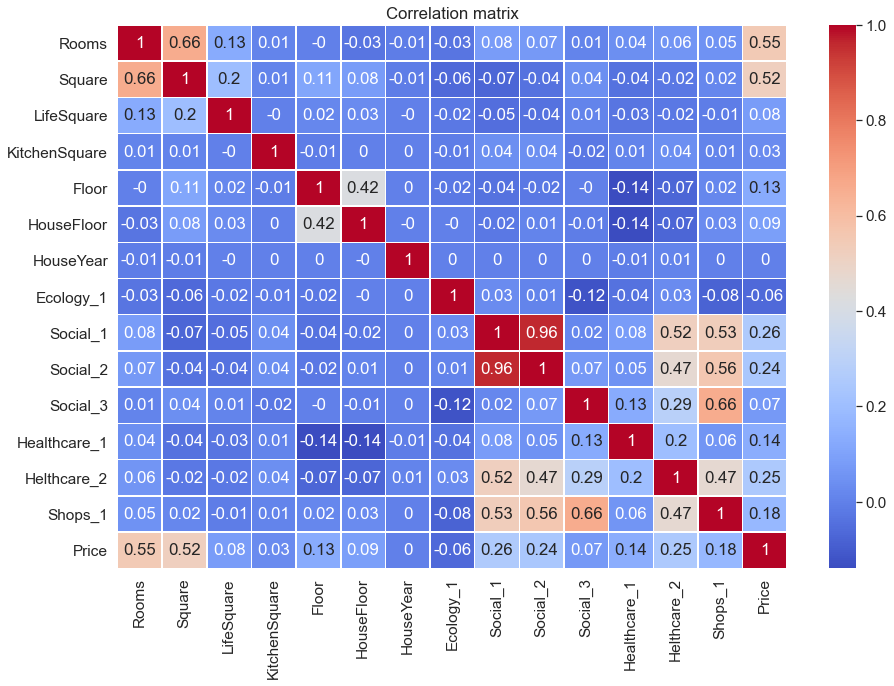

In [29]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = train_df.corr()
corr_matrix = np.round(corr_matrix, 2)
#corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

Наиболее сильная положительная корреляция между признаками Social_1-Social_2.

Наиболее сильная отрицательная корреляция между признаками Healthcare_1-Floor и HouseFloor-HealthCare_1.

С Price лучше всего коррелируют признаки Rooms и Square. Отрицательная корреляция с Price у признака Ecology_1.

### Анализ зависимости таргета от фичей

Text(0, 0.5, 'Price')

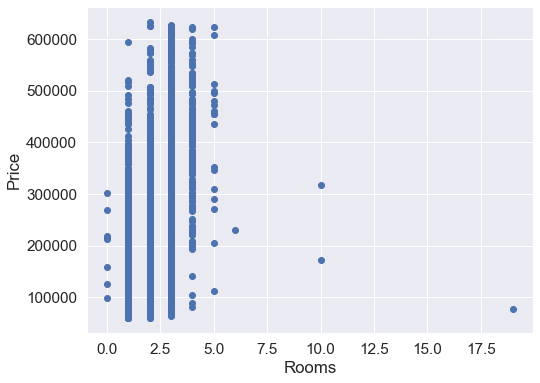

In [30]:
plt.figure(figsize=(8,6))
plt.scatter(x=train_df['Rooms'],y=train_df['Price'])
plt.xlabel('Rooms')
plt.ylabel('Price')

Данный график подтверждает, что в признаке Rooms скорее всего содержатся выбросы при количестве комнат в квартире, превышающих 5 (крайние правые 4 точки на графике). Помимо этого, можно увидеть, что цены за квартиры с одинаковым количеством комнат существенно отличаются. Можно предположить, что цена за квартиру формируется не только исходя из количества комнат в ней, но и зависит от других признаков (например от района, в котором эта квартира находится).  

Text(0, 0.5, 'Price')

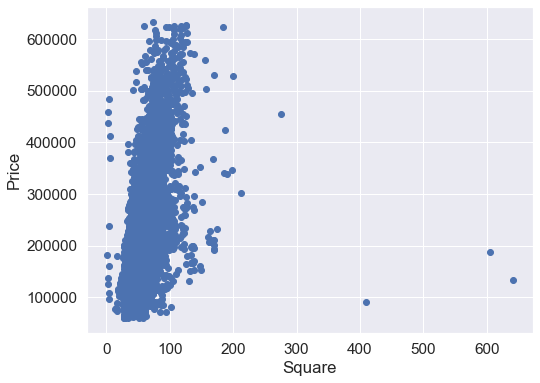

In [31]:
plt.figure(figsize=(8,6))
plt.scatter(x=train_df['Square'],y=train_df['Price'])
plt.xlabel('Square')
plt.ylabel('Price')

Зависимость цены от общей площади показывает, что с увеличением площади цена растет. Кроме этого, в признаке Square есть выбросы.

[Text(0.5, 0, 'LifeSquare'), Text(0, 0.5, 'Price')]

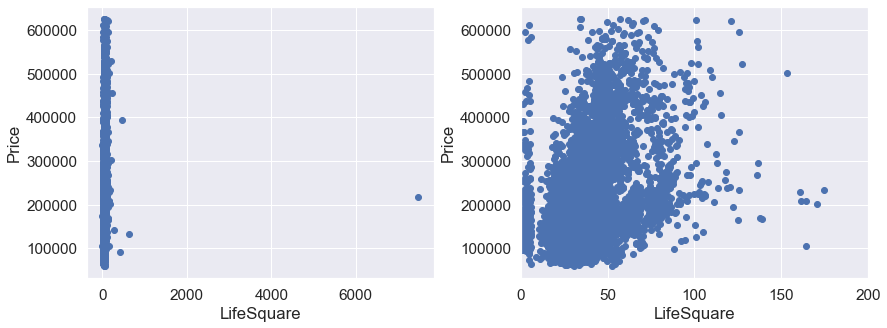

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
fig.subplots_adjust(wspace=0.25)
ax[0].scatter(x=train_df['LifeSquare'],y=train_df['Price'])
ax[0].set(xlabel='LifeSquare', ylabel='Price')
ax[1].scatter(x=train_df['LifeSquare'],y=train_df['Price'])
ax[1].set_xlim([0, 200])
ax[1].set(xlabel='LifeSquare', ylabel='Price')


Зависимость цены от жилой площади также показывает, что в признаке LifeSquare есть выбросы.Также можно отметить, что в целом увеличение жилой площади приводит к увеличению цены. 

[Text(0.5, 0, 'KitchenSquare'), Text(0, 0.5, 'Price')]

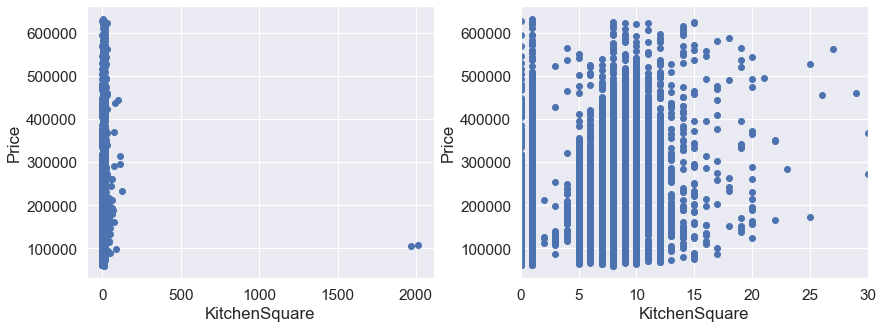

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
fig.subplots_adjust(wspace=0.25)
ax[0].scatter(x=train_df['KitchenSquare'],y=train_df['Price'])
ax[0].set(xlabel='KitchenSquare', ylabel='Price')
ax[1].scatter(x=train_df['KitchenSquare'],y=train_df['Price'])
ax[1].set_xlim([0, 30])
ax[1].set(xlabel='KitchenSquare', ylabel='Price')

Зависимость цены от площади кухни показывает, что признак KitchenSquare также содержит выбросы (данные с очень большой площадью кухни). Кроме этого, есть данные, в которых площадь кухни крайне мала, что тоже скорее всего является ошибкой. Четко выраженного тренда на рост стоимости квартиры в зависимости от роста площади кухни данные не показывают.

Text(0, 0.5, 'Price')

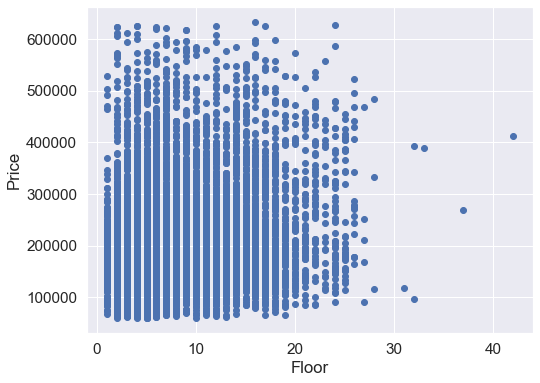

In [34]:
plt.figure(figsize=(8,6))
plt.scatter(x=train_df['Floor'],y=train_df['Price'])
plt.xlabel('Floor')
plt.ylabel('Price')

Явного тренда на зависимость стоимости квартиры от этажа не прослеживается

Text(0, 0.5, 'Price')

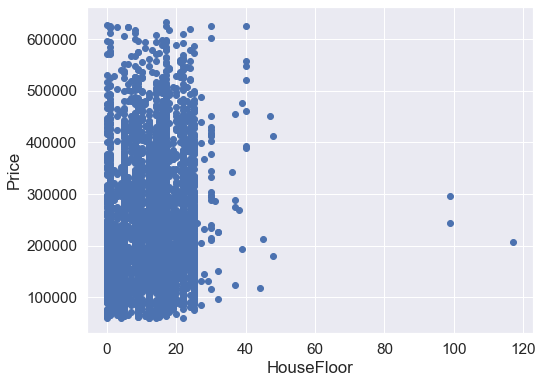

In [35]:
plt.figure(figsize=(8,6))
plt.scatter(x=train_df['HouseFloor'],y=train_df['Price'])
plt.xlabel('HouseFloor')
plt.ylabel('Price')

Признак HouseFloor содержит выбросы после значения 60. Явная зависимость стоимости от количества этажей в доме не прослеживается.

[Text(0.5, 0, 'HouseYear'), Text(0, 0.5, 'Price')]

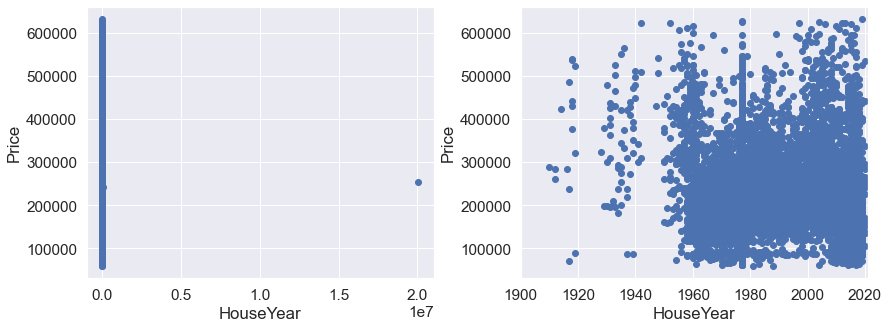

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(14, 5)
fig.subplots_adjust(wspace=0.25)
ax[0].scatter(x=train_df['HouseYear'],y=train_df['Price'])
ax[0].set(xlabel='HouseYear', ylabel='Price')
ax[1].scatter(x=train_df['HouseYear'],y=train_df['Price'])
ax[1].set_xlim([1900, 2021])
ax[1].set(xlabel='HouseYear', ylabel='Price')

Признак HouseYear содержит явные выбросы. Дорогая недвижимость есть как в старых, так и в новых домах.

[Text(0.5, 0, 'Helthcare_2'), Text(0, 0.5, 'Price')]

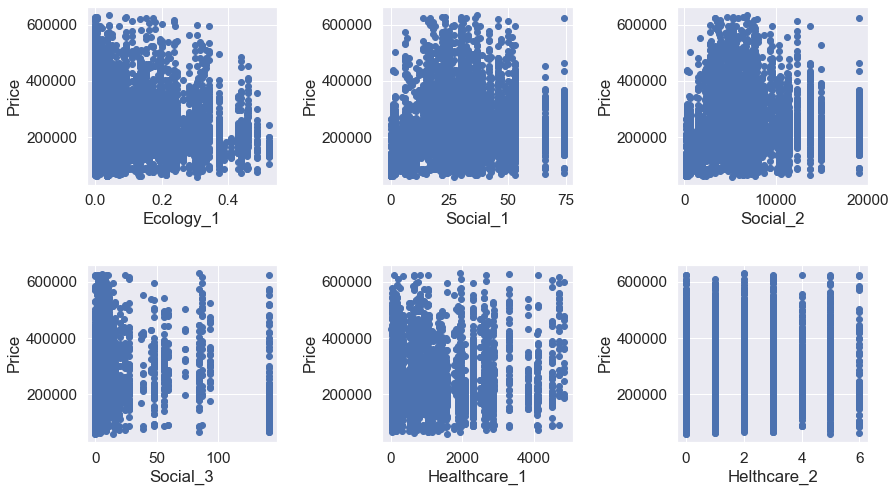

In [37]:
fig, ax = plt.subplots(nrows=2, ncols=3)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()
fig.set_size_inches(14, 8)
fig.subplots_adjust(wspace=0.55, hspace=0.45)
ax1.scatter(x=train_df['Ecology_1'],y=train_df['Price'])
ax1.set(xlabel='Ecology_1', ylabel='Price')
ax2.scatter(x=train_df['Social_1'],y=train_df['Price'])
ax2.set(xlabel='Social_1', ylabel='Price')
ax3.scatter(x=train_df['Social_2'],y=train_df['Price'])
ax3.set(xlabel='Social_2', ylabel='Price')
ax4.scatter(x=train_df['Social_3'],y=train_df['Price'])
ax4.set(xlabel='Social_3', ylabel='Price')
ax5.scatter(x=train_df['Healthcare_1'],y=train_df['Price'])
ax5.set(xlabel='Healthcare_1', ylabel='Price')
ax6.scatter(x=train_df['Helthcare_2'],y=train_df['Price'])
ax6.set(xlabel='Helthcare_2', ylabel='Price')

В признаках Ecology_1, Social_1, Social_2, Social_3, Healthcare_1, Helthcare_2 не содержатся явные выбросы.

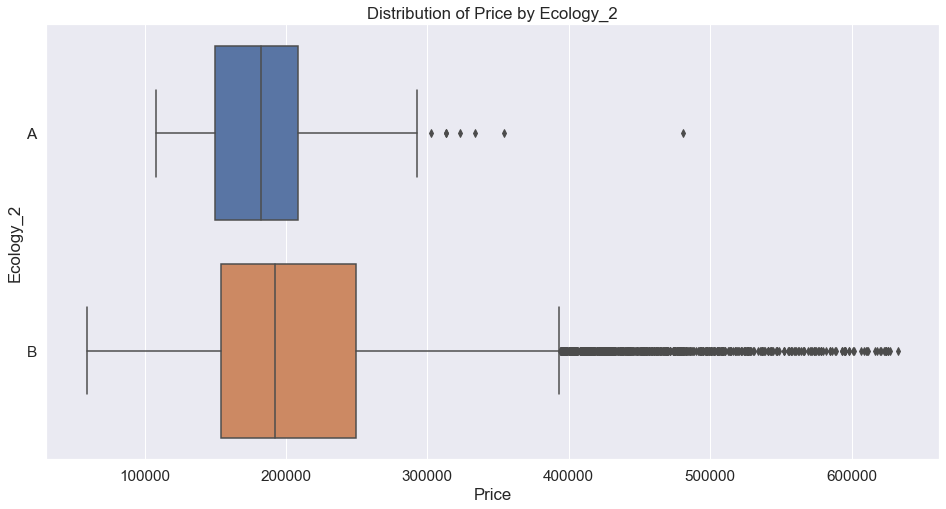

In [38]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Ecology_2'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Ecology_2')
plt.title('Distribution of Price by Ecology_2')
plt.show()

Медиана стоимости квартиры с показателем экологии Ecology_2 В выше, чем с показателем A.

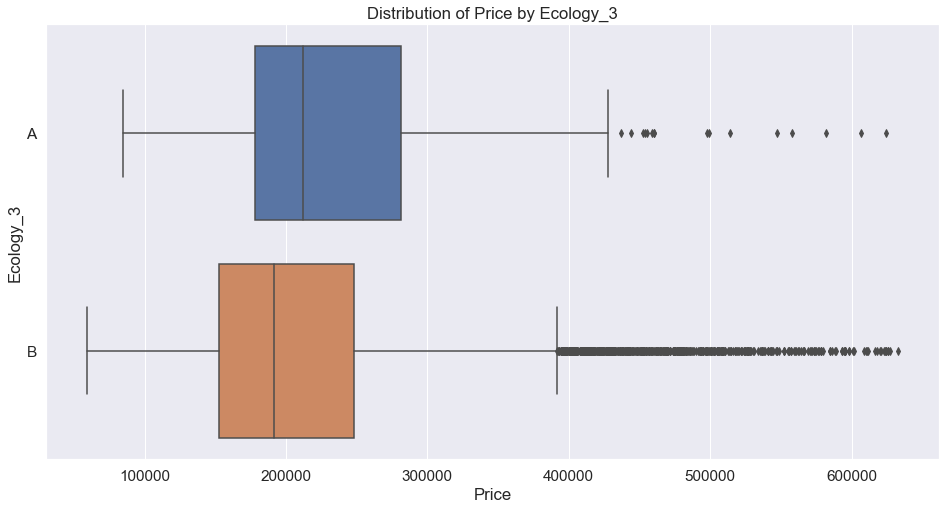

In [39]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Ecology_3'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Ecology_3')
plt.title('Distribution of Price by Ecology_3')
plt.show()

Медиана стоимости квартиры с показателем экологии Ecology_3 А выше, чем с показателем B.

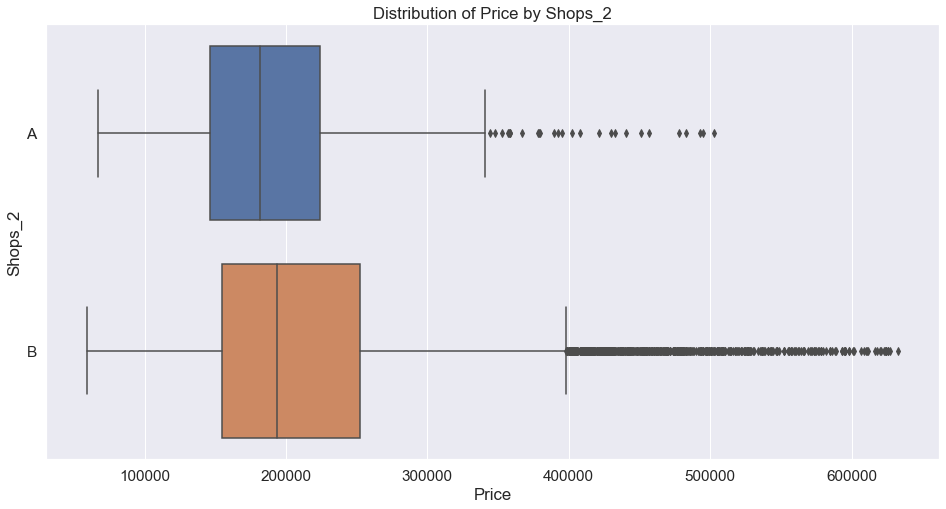

In [40]:
plt.figure(figsize=(16, 8))

sns.boxplot(train_df['Price'], train_df['Shops_2'], whis=1.5)

plt.xlabel('Price')
plt.ylabel('Shops_2')
plt.title('Distribution of Price by Shops_2')
plt.show()

Медиана стоимости квартиры с показателем магазинов Shops_2 B выше, чем с показателем A.

## 3.2 Очистка данных и Feature Engineering

In [41]:
train_df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

В признаке LifeSquare пропущено 2113 строк, в признаке Healthcare_1 пропущено 4798 строк.

Для заполнения пропущенных данных и обработки выбросов создадим класс DataPreprocessing.

In [42]:
class DataPreprocessing:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.KitchenSquare_max_value=None
        self.KitchenSquare_min_value=None
        self.LifeSquare_max_value=None
        self.LifeSquare_min_value=None
        self.groupby_KS = None
        self.groupby_KS_median = None
        self.groupby_S = None
        self.groupby_S_median = None
        
        
    def fit(self, X):
        """Сохранение статистик"""
        
       # Medians and quantiles
        self.medians = X.median() # medians
        self.KitchenSquare_max_value=np.quantile(X['KitchenSquare'], q=0.975) #97,5% квантиль признака KitchenSquare 
        self.KitchenSquare_min_value=np.quantile(X['KitchenSquare'], q=0.025) #2,5% квантиль признака KitchenSquare
        self.LifeSquare_max_value=np.quantile(X['LifeSquare'], q=0.975) #97,5% квантиль признака LifeSquare
        self.LifeSquare_min_value=np.quantile(X['LifeSquare'], q=0.025) #2,5% квантиль признака LifeSquare
            
        #Вспомогательные параметры
        df = X.copy()
        self.groupby_KS=df.groupby(['DistrictId'], as_index=False).\
                        agg({'KitchenSquare':'median'}).rename(columns={'KitchenSquare':'Median_KS'})
        self.groupby_KS_median = self.groupby_KS['Median_KS'].median()
        self.groupby_S=df.groupby(['DistrictId'], as_index=False).\
                        agg({'Square':'median'}).rename(columns={'Square':'Median_S'})
        self.groupby_S_median = self.groupby_S['Median_S'].median()
        #значения, меньшие 3, заменим на медиану 
        self.groupby_KS.loc[self.groupby_KS['Median_KS']<3, 'Median_KS']=self.groupby_KS_median
        #значения, меньшие 10, заменим на медиану
        self.groupby_S.loc[self.groupby_S['Median_S']<10, 'Median_S']=self.groupby_S_median
        
        
    def transform(self, X):
        """Трансформация данных"""
        
        # 1. Обработка пропусков
        
        #1.1 LifeSquare
        # Заменним пропуски на величину X['Square']-X['KitchenSquare']-0.15*X['Square']
        X.loc[X['LifeSquare'].isnull(), 'LifeSquare'] =\
                            X.loc[X['LifeSquare'].isnull(), 'Square'] -\
                            X.loc[X['LifeSquare'].isnull(), 'KitchenSquare'] - 0.15*X.loc[X['LifeSquare'].isnull(), 'Square']
        #Если получились отрицательные значения, то заменим их на медиану признака LifeSquare
        X.loc[X['LifeSquare']<0, 'LifeSquare'] = X['LifeSquare'].median()

        #1.2 Healthcare_1
        # Healthcare_1 заполним медианами
        X[['Healthcare_1']] = X[['Healthcare_1']].fillna(self.medians['Healthcare_1'])
         
        # 2. Обработка выбросов (outliers)  
        
        # 2.1 Rooms
        
        # Выбросами являются количество комнат, равное 0 и количество комнат, превышающее 5
        # Т.к. количество комнат - целочисленный признак, то заполним выбросы медианами.
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] > 5), 'Rooms'] = self.medians['Rooms']              

        #2.2 Square, KitchenSquare и LifeSquare
        
        #В случае, если общая площадь меньше, чем жилая площадь, то поменяем им местами
        X['Square'], X['LifeSquare'] = np.where(X['Square'] < X['LifeSquare'],\
                            (X['LifeSquare'], X['Square']), (X['Square'],X['LifeSquare']))
        
        # Определим выбросы в признаках LifeSquare и KitchenSquare с помощью квантилей.
        #Наблюдения, значения которых больше 97,5% квантиля и которые меньше 2,5% квантиля 
        #будем считать выбросами и заменять на медиану.     
        condition1 = (X['KitchenSquare'].isna()) | (X['KitchenSquare'] > self.KitchenSquare_max_value) | \
                     (X['KitchenSquare'] < self.KitchenSquare_min_value)
        X.loc[condition1, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        condition2 = (X['LifeSquare'].isna()) | (X['LifeSquare'] > self.LifeSquare_max_value) | \
                     (X['LifeSquare'] < self.LifeSquare_min_value)
        X.loc[condition2, 'LifeSquare'] = self.medians['LifeSquare']
        
       
        #Слишком маленькие значения KitchenSquare (<3) и Square (<10) заменим на медианы по району
        X = X.merge(self.groupby_KS, on=['DistrictId'], how='left')
        condition4=(X['KitchenSquare'] < 3)
        X.loc[condition4, 'KitchenSquare']=X['Median_KS']
        X.drop("Median_KS", axis=1, inplace=True)
        #Если есть пропуски в KitchenSquare, то заменяем их медианой
        X['KitchenSquare'].fillna(self.groupby_KS_median, inplace=True)

        X = X.merge(self.groupby_S, on=['DistrictId'], how='left')
        condition5=(X['Square'] < 10)
        X.loc[condition5, 'Square']=X['Median_S']
        X.drop("Median_S", axis=1, inplace=True)
        #Если есть пропуски в Square, то заменяем их медианой
        X['Square'].fillna(self.groupby_S_median, inplace=True)
           

        #2.3 HouseFloor, Floor  
                       
        #Заменим количество этажей в доме, равное 0 и количество этажей в доме, 
        #превышающее 60, медианой, поскольку этаж - это целочисленный признак 
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] > 60), 'HouseFloor'] = \
                                                        self.medians['HouseFloor']
        
        #Если значение этажа квартиры превышает общее количество этажей в доме, то поменяем
        #их местами
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] =  X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        
        #2.4 HouseYear
        
        #Года, превышающие текущий год, заменяем на текущее значение года
        current_year=datetime.now().year
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
                               
        
        return X
    

Для генерации новых признаков создадим класс FeatureGeneratore

In [43]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.groupEcology_2 = None
        self.groupEcology_3 = None
        self.groupShops_2 = None
        self.district_size = None
        self.district_mode = None
        self.mean_price_by_Sq_m = None
        self.mean_price_by_Sq_m_mean = None
        self.med_price_by_HealthCare_1 =None
        self.med_price_by_HealthCare_1_median = None
        self.med_price_by_Social_3 = None
        self.med_price_by_Social_3_median = None
        self.med_Life_by_Rooms = None
        self.med_Life_by_Rooms_median = None

        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictSize
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        self.district_mode = X['DistrictId'].mode()[0]  
        
        # Target encoding
        df = X.copy()
        
        #Расчет медианы стоимости квартиры в зависимости от признаков Ecology_2, Ecology_3, Shops_2 
        if y is not None:
            df['Price'] = y.values
            self.groupEcology_2 = df.groupby('Ecology_2')['Price'].median()
            self.groupEcology_3 = df.groupby('Ecology_3')['Price'].median()
            self.groupShops_2 = df.groupby('Shops_2')['Price'].median()
            
        #Расчет средней цены за кв м в зависимости от района
        if y is not None:
            df['Price'] = y.values
            df['price_per_sqm'] = df['Price'] / df['Square']
            self.mean_price_by_Sq_m_mean = df['price_per_sqm'].mean()
            self.mean_price_by_Sq_m = df.groupby(['DistrictId'], as_index=False).agg({'price_per_sqm':'mean'})\
                            .rename(columns={'price_per_sqm':'MeanPriceBySq_m'})
            df.drop('price_per_sqm', axis=1, inplace=True)      
          

       #Расчет медианы стоимости квартиры в зависиомости от района и признака Healthcare_1 
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_HealthCare_1 = df.groupby(['DistrictId','Healthcare_1'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByHealthCare_1'}) 
            self.med_price_by_HealthCare_1_median = self.med_price_by_HealthCare_1['MedPriceByHealthCare_1'].median()
                  
        #Расчет медианы стоимости квартиры в зависимости от района и признака Social_3    
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_Social_3 = df.groupby(['DistrictId','Social_3'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceBySocial_3'})
            self.med_price_by_Social_3_median = self.med_price_by_Social_3['MedPriceBySocial_3'].median()  

            
        #Расчет медианы жилой площади в зависимости от количества комнат
        self.med_Life_by_Rooms = df.groupby(['Rooms'], as_index=False).agg({'LifeSquare':'median'})\
                            .rename(columns={'LifeSquare':'MedLifeByRooms'})
        self.med_Life_by_Rooms_median = self.med_Life_by_Rooms['MedLifeByRooms'].median() 
            
        
    def transform(self, X):
        
        # Кодирование категориальных признаков Ecology_2, Ecology_3, Shops_2 по медиане цены
        X['Ecology_2_mean_price'] = X['Ecology_2'].map(self.groupEcology_2)
        X['Ecology_2_mean_price'] = X['Ecology_2_mean_price'].astype('float32')
        X['Ecology_3_mean_price'] = X['Ecology_3'].map(self.groupEcology_3)
        X['Ecology_3_mean_price'] = X['Ecology_3_mean_price'].astype('float32')
        X['Shops_2_mean_price'] = X['Shops_2'].map(self.groupShops_2)
        X['Shops_2_mean_price'] = X['Shops_2_mean_price'].astype('float32')       

        # Признак, определяющий размер района (DistrictSize)
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['DistrictSize'].fillna(self.district_mode, inplace=True)
        X['DistrictSize']=X['DistrictSize'].astype('int64')

        #Медиана стоимости квартиры в зависмости от района и показателя здравоохранения Healthcare_1 (MedPriceByHealthCare_1)
        X = X.merge(self.med_price_by_HealthCare_1, on=['DistrictId','Healthcare_1'], how='left')
        X['MedPriceByHealthCare_1'].fillna(self.med_price_by_HealthCare_1_median, inplace=True) 

        #Медиана стоимости квартиры в зависмости от района и социального показателя Social_3 (MedPriceBySocial_3)
        X = X.merge(self.med_price_by_Social_3, on=['DistrictId','Social_3'], how='left')
        X['MedPriceBySocial_3'].fillna(self.med_price_by_Social_3_median, inplace=True)       
    
        # Средняя цена за кв м в зависимости от района (MeanPriceBySq_m)
        X = X.merge(self.mean_price_by_Sq_m, on=['DistrictId'], how='left')
        X['MeanPriceBySq_m'].fillna(self.mean_price_by_Sq_m_mean, inplace=True)  
              
        # Признак, возвращающий категорию дома в зависимости от года его постройки
        X=self.age_to_cat(X)
               
        # Признак, отделяющий квартиры на первом или последнем этажах
        X=self.floor_to_cat(X)
        
        # Признак, отделяющий квартиры с количеством комнат более 3
        X=self.room_to_cat(X)        
        
        # Признак, отделяющий квартиры с площадью кухни более 8
        X=self.kitchensize_to_cat(X)                
        
        # Медиана жилой площади квартиры в зависимости от количества комнат (MedLifeByRooms)
        X = X.merge(self.med_Life_by_Rooms, on=['Rooms'], how='left')
        X['MedLifeByRooms'].fillna(self.med_Life_by_Rooms_median, inplace=True) 
        
               
        return X
    
    def age_to_cat(self, X):

        X['HouseYear_cat'] = 0

        X.loc[X['HouseYear'] <= 1941, 'HouseYear_cat'] = 1  
        X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1960), 'HouseYear_cat'] = 2
        X.loc[(X['HouseYear'] > 1960) & (X['HouseYear'] <= 1980), 'HouseYear_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'HouseYear_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'HouseYear_cat'] = 5
        X.loc[X['HouseYear'] > 2010, 'HouseYear_cat'] = 6

        return X
     
    def floor_to_cat(self, X):

        X['Floor_cat'] = 1
        
        X.loc[(X['Floor']==X['HouseFloor'])|(X['Floor']==1),'Floor_cat'] = 0

        return X
 
    def room_to_cat(self, X):

        X['Room_cat'] = 0

        X.loc[X['Floor'] <= 3, 'Room_cat'] = 0  
        X.loc[X['Floor'] > 3,  'Room_cat'] = 1

        return X
    
    def kitchensize_to_cat(self, X):
        
        X['KitchenSize_cat'] = 0

        X.loc[X['KitchenSquare'] > 8,  'KitchenSize_cat'] = 1

        return X
    

In [44]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)
train_df_prep = preprocessor.transform(train_df)

In [45]:
train_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  object  
 1   DistrictId     10000 non-null  object  
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     10000 non-null  float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  float32 
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   10000 non-null  float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [46]:
test_df_prep=preprocessor.transform(test_df)

In [47]:
test_df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   object  
 1   DistrictId     5000 non-null   object  
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     5000 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   float32 
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   5000 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [48]:
target_name = 'Price'
X = train_df_prep.drop(columns=target_name)
y = train_df_prep[target_name]

features_gen = FeatureGenetator()
features_gen.fit(X, y)
X = features_gen.transform(X)

In [49]:
X.shape

(10000, 31)

In [50]:
X.isna().sum().sum()

0

In [51]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Id                      10000 non-null  object  
 1   DistrictId              10000 non-null  object  
 2   Rooms                   10000 non-null  float32 
 3   Square                  10000 non-null  float32 
 4   LifeSquare              10000 non-null  float32 
 5   KitchenSquare           10000 non-null  float32 
 6   Floor                   10000 non-null  float32 
 7   HouseFloor              10000 non-null  float32 
 8   HouseYear               10000 non-null  int32   
 9   Ecology_1               10000 non-null  float32 
 10  Ecology_2               10000 non-null  category
 11  Ecology_3               10000 non-null  category
 12  Social_1                10000 non-null  int8    
 13  Social_2                10000 non-null  int16   
 14  Social_3               

In [52]:
test_df = features_gen.transform(test_df_prep)

In [53]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Id                      5000 non-null   object  
 1   DistrictId              5000 non-null   object  
 2   Rooms                   5000 non-null   float32 
 3   Square                  5000 non-null   float32 
 4   LifeSquare              5000 non-null   float32 
 5   KitchenSquare           5000 non-null   float32 
 6   Floor                   5000 non-null   float32 
 7   HouseFloor              5000 non-null   float32 
 8   HouseYear               5000 non-null   int16   
 9   Ecology_1               5000 non-null   float32 
 10  Ecology_2               5000 non-null   category
 11  Ecology_3               5000 non-null   category
 12  Social_1                5000 non-null   int8    
 13  Social_2                5000 non-null   int16   
 14  Social_3                

In [54]:
test_df.shape

(5000, 31)

In [55]:
test_df.isna().sum().sum()

0

### 3. 3 Отбор признаков 

In [56]:
X.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Ecology_2_mean_price',
 'Ecology_3_mean_price',
 'Shops_2_mean_price',
 'DistrictSize',
 'MedPriceByHealthCare_1',
 'MedPriceBySocial_3',
 'MeanPriceBySq_m',
 'HouseYear_cat',
 'Floor_cat',
 'Room_cat',
 'KitchenSize_cat',
 'MedLifeByRooms']

In [57]:
feature_names = ['Rooms',              
 'Square',
 'LifeSquare',
 'KitchenSquare', 
 'HouseFloor',                
 'HouseYear',                             
 'Ecology_1',
 'Healthcare_1',                
 'Ecology_2_mean_price',
 'Ecology_3_mean_price',
 'Shops_2_mean_price', 
 'DistrictSize',                
 'MeanPriceBySq_m',
 'HouseYear_cat',
 'Floor_cat',
 'Room_cat',
 'KitchenSize_cat',
 'MedPriceByHealthCare_1',              
 'MedPriceBySocial_3',                 
 'Shops_1',
 'MedLifeByRooms'               
]

In [58]:
X = X[feature_names]
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rooms                   10000 non-null  float32
 1   Square                  10000 non-null  float32
 2   LifeSquare              10000 non-null  float32
 3   KitchenSquare           10000 non-null  float32
 4   HouseFloor              10000 non-null  float32
 5   HouseYear               10000 non-null  int32  
 6   Ecology_1               10000 non-null  float32
 7   Healthcare_1            10000 non-null  float32
 8   Ecology_2_mean_price    10000 non-null  float32
 9   Ecology_3_mean_price    10000 non-null  float32
 10  Shops_2_mean_price      10000 non-null  float32
 11  DistrictSize            10000 non-null  int64  
 12  MeanPriceBySq_m         10000 non-null  float32
 13  HouseYear_cat           10000 non-null  int64  
 14  Floor_cat               10000 non-null 

In [59]:
test_df = test_df[feature_names]
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Rooms                   5000 non-null   float32
 1   Square                  5000 non-null   float32
 2   LifeSquare              5000 non-null   float32
 3   KitchenSquare           5000 non-null   float32
 4   HouseFloor              5000 non-null   float32
 5   HouseYear               5000 non-null   int16  
 6   Ecology_1               5000 non-null   float32
 7   Healthcare_1            5000 non-null   float32
 8   Ecology_2_mean_price    5000 non-null   float32
 9   Ecology_3_mean_price    5000 non-null   float32
 10  Shops_2_mean_price      5000 non-null   float32
 11  DistrictSize            5000 non-null   int64  
 12  MeanPriceBySq_m         5000 non-null   float32
 13  HouseYear_cat           5000 non-null   int64  
 14  Floor_cat               5000 non-null   

## 4. Разбиение на train и test

In [60]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=100)

In [61]:
X_train.shape, X_valid.shape

((8000, 21), (2000, 21))

## 5. Обучение и оценка модели

Train R2:	0.807
Test R2:	0.743


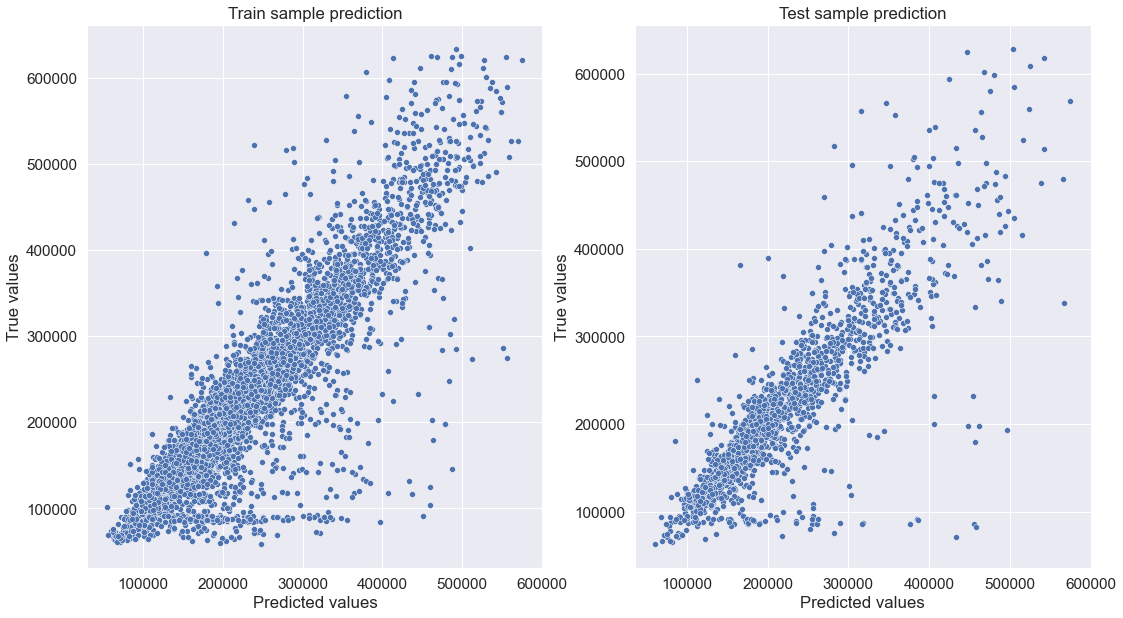

In [62]:
final_model = GradientBoostingRegressor(criterion='mse',
                                        max_depth=2,
                                        max_features='log2',
                                        n_estimators=4000,
                                        min_samples_leaf=100,
                                        random_state=42,
                                        learning_rate=0.06,
                                        warm_start=True,
                                        loss='huber')

final_model.fit(X_train, y_train)
y_train_preds = final_model.predict(X_train)
y_test_preds = final_model.predict(X_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

#### Важность признаков

In [63]:
feature_importances = pd.DataFrame(zip(X_train.columns, 
                                       final_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

#### Топ-3 фичи

In [64]:
feature_importances.head(3)

,feature_name,importance
1,Square,0.206113
17,MedPriceByHealthCare_1,0.157457
18,MedPriceBySocial_3,0.144337


#### Худшие 3 фичи

In [65]:
feature_importances.tail(3)

,feature_name,importance
10,Shops_2_mean_price,0.000297
9,Ecology_3_mean_price,0.000042
8,Ecology_2_mean_price,0.000000


## 6. Прогнозирование на тестовом датасете

In [66]:
test_df.shape

(5000, 21)

In [67]:
submit = pd.read_csv('./sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [68]:
predictions = final_model.predict(test_df)
predictions

array([168240.24833376, 120405.07469779, 152125.92955492, ...,
       156759.38054305, 191900.03833963, 276283.24887796])

In [69]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,168240.248334
1,5925,120405.074698
2,960,152125.929555
3,3848,91344.113383
4,746,163430.587378


In [70]:
submit.to_csv('AKostina_predictions.csv', index=False)